In [1]:
!pip install gensim tsfresh numpy scipy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tsfresh to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: tsfresh
    Found existing installation: tsfresh 0.21.0
    Uninstalling tsfresh-0.21.0:
      Successfully uninstalled tsfresh-0.21.0


In [2]:
import numpy as np
import pandas as pd

df=pd.read_csv('IMDB Dataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**We are required to do basic preprocessing for the texts to convert them to vectors for Neural Models to learn and predict**

In [3]:
#**We will begin with encoding the sentiment column to map positive as -->1 and negative as -->0**

df['sentiment']=df['sentiment'].map({'positive':1,'negative':0})
df['sentiment'].value_counts()

,count
sentiment,
1,25000
0,25000


**Text PreProcessing steps**

Preprocessing Steps
1. **HTML Cleaning & Text Normalization**

Remove HTML tags
Convert text to lowercase for consistency
Handling contractions (e.g., "don't" --> "do not", "can't" --> "cannot")
Remove URLs and email addresses

2. **Punctuation & Symbol Handling**

Remove numbers and special characters
We keep only alphabetic characters and spaces
Clean extra whitespaces

3. **Tokenization & Stop Words Removal**

Split text into individual tokens/words
Remove common stop words (the, is, at, which...)
Filter out tokens shorter than 3 characters

4. **Lemmatization with POS Tagging**

Apply POS (Part-of-Speech) tagging for better lemmatization
Convert words to their base forms (e.g., "running" --> "run")
This preserves semantic meaning better than stemming

5. **Vocabulary Building & Rare Word Filtering**

Count word frequencies across the dataset
Remove words appearing less than 2 times (reduces noise)
This builds clean vocabulary for Word2Vec training

**Expected Output**

List of clean token lists ready for Word2Vec model
['terrible', 'film', 'waste', 'time']]


In [4]:
#HTML cleaning and text normalization

import re
import nltk

# Download required data
nltk.download('punkt')

print(f"Dataset loaded: {len(df)} reviews")

# Contraction mapping
contractions = {
    "won't": "will not", "can't": "cannot", "n't": " not",
    "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
    "'m": " am", "it's": "it is", "that's": "that is",
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "isn't": "is not", "wasn't": "was not", "weren't": "were not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
    "won't": "will not", "wouldn't": "would not", "shouldn't": "should not",
    "couldn't": "could not", "mustn't": "must not"
}

def clean_and_normalize_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'<.*?',' ',text) # Remove HTML tags
    text = text.lower() #Convert to lowercase

    for contraction, expansion in contractions.items(): # Handle contractions
        text = text.replace(contraction, expansion)

    text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', text)# Remove URLs and emails

    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespaces

    return text

# Apply to the entire dataset
print("Step 1: HTML Cleaning & Text Normalization...")
df['cleaned_text'] = df['review'].apply(clean_and_normalize_text)

#example
print("Original:", df['review'].iloc[0][:100])
print("Cleaned:", df['cleaned_text'].iloc[0][:100])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dataset loaded: 50000 reviews
Step 1: HTML Cleaning & Text Normalization...
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The
Cleaned: one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked. t


In [5]:
#Punctuation & Symbol Handling

import string

def clean_punctuation_symbols(text):

    text = re.sub(r'\d+', '', text)# Remove numbers

    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remove special characters, keep only letters and spaces

    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespaces

    return text

# Apply to entire dataset
print("\nStep 2: Punctuation & Symbol Handling...")
df['punct_cleaned'] = df['cleaned_text'].apply(clean_punctuation_symbols)

# Show example
print("Before:", df['cleaned_text'].iloc[0][:100])
print("After:", df['punct_cleaned'].iloc[0][:100])


Step 2: Punctuation & Symbol Handling...
Before: one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked. t
After: one of the other reviewers has mentioned that after watching just oz episode you will be hooked they


In [7]:
#Tokenization & Stop Words Removal
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text) # Word Tokenize

    tokens = [token for token in tokens if token not in stop_words and len(token) > 2] # Remove stop words and short tokens

    return tokens

# Apply to entire dataset
print("\nStep 3: Tokenization & Stop Words Removal...")
df['tokens'] = df['punct_cleaned'].apply(tokenize_and_remove_stopwords)

#example
print("Before:", df['punct_cleaned'].iloc[0][:100])
print("Tokens:", df['tokens'].iloc[0][:10])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Step 3: Tokenization & Stop Words Removal...
Before: one of the other reviewers has mentioned that after watching just oz episode you will be hooked they
Tokens: ['one', 'reviewers', 'mentioned', 'watching', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first']


In [8]:
#Lemmatization with POS Tagging

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)  # Updated download name
nltk.download('averaged_perceptron_tagger', quiet=True)      # Fallback

lemmatizer = WordNetLemmatizer()

def get_pos_tag(word):
    tag = nltk.pos_tag([word])[0][1]

    if tag.startswith('J'):  # Adjective
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verb
        return wordnet.VERB
    elif tag.startswith('N'):  # Noun
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_with_pos(tokens):
    lemmatized = []
    for token in tokens:
        # Get POS tag for better lemmatization
        pos_tag = get_pos_tag(token)
        lemmatized_word = lemmatizer.lemmatize(token, pos_tag)
        lemmatized.append(lemmatized_word)
    return lemmatized

# Apply to entire dataset
print("\nStep 4: Lemmatization with POS Tagging...")
df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_with_pos)

#example
print("Before lemmatization:", df['tokens'].iloc[0][:10])
print("After lemmatization:", df['lemmatized_tokens'].iloc[0][:10])


Step 4: Lemmatization with POS Tagging...
Before lemmatization: ['one', 'reviewers', 'mentioned', 'watching', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first']
After lemmatization: ['one', 'reviewer', 'mention', 'watch', 'episode', 'hooked', 'right', 'exactly', 'happen', 'first']


In [9]:
#Vocabulary Building & Rare Word Filtering

from collections import Counter
import numpy as np

def build_vocabulary_and_filter(token_lists, min_freq=2):

    print("Building vocabulary...") # Count all words
    all_words = []
    for tokens in token_lists:
        all_words.extend(tokens)

    word_freq = Counter(all_words) # Build frequency dictionary
    print(f"Total vocabulary size: {len(word_freq)}")

    frequent_words = set(word for word, freq in word_freq.items() if freq >= min_freq) # Keep frequent words
    print(f"Words with frequency >= {min_freq}: {len(frequent_words)}")

    filtered_tokens = [] # Filter tokens
    for tokens in token_lists:
        filtered = [token for token in tokens if token in frequent_words]
        if len(filtered) > 0:  # Keeps only non-empty reviews
            filtered_tokens.append(filtered)

    return filtered_tokens, word_freq

# Apply to entire dataset
print("\nStep 5: Vocabulary Building & Rare Word Filtering...")
final_tokens, vocab_freq = build_vocabulary_and_filter(df['lemmatized_tokens'], min_freq=2)

# basic stats
print(f"Original reviews: {len(df)}")
print(f"Final processed reviews: {len(final_tokens)}")
print(f"Average tokens per review: {np.mean([len(tokens) for tokens in final_tokens]):.1f}")

# example
for i in range(3):
    print(f"Review {i+1}: {final_tokens[i][:15]}...")


Step 5: Vocabulary Building & Rare Word Filtering...
Building vocabulary...
Total vocabulary size: 82890
Words with frequency >= 2: 49415
Original reviews: 50000
Final processed reviews: 50000
Average tokens per review: 116.1
Review 1: ['one', 'reviewer', 'mention', 'watch', 'episode', 'hooked', 'right', 'exactly', 'happen', 'first', 'thing', 'struck', 'brutality', 'unflinching', 'scene']...
Review 2: ['wonderful', 'little', 'production', 'film', 'technique', 'unassuming', 'old', 'time', 'bbc', 'fashion', 'give', 'comfort', 'sometimes', 'discomforting', 'sense']...
Review 3: ['thought', 'wonderful', 'way', 'spend', 'time', 'hot', 'summer', 'weekend', 'sit', 'air', 'condition', 'theater', 'watch', 'light', 'hearted']...


In [10]:
df.head(5)

,review,sentiment,cleaned_text,punct_cleaned,tokens,lemmatized_tokens
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, episode,...","[one, reviewer, mention, watch, episode, hooke..."
1,A wonderful little production. <br /><br />The...,1,a wonderful little production. br /> br />the ...,a wonderful little production br br the filmin...,"[wonderful, little, production, filming, techn...","[wonderful, little, production, film, techniqu..."
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,0,basically there's a family where a little boy ...,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"petter mattei's ""love in the time of money"" is...",petter mattei s love in the time of money is a...,"[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visually, ..."


In [11]:
#Word2Vec
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=final_tokens,
    vector_size=100,   # embedding size
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

In [12]:
def get_review_vector(tokens, model, vector_size=100):
    """Average Word2Vec vectors for each review"""
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if len(vectors) == 0:
        return np.zeros(vector_size)  # empty review fallback
    return np.mean(vectors, axis=0)

In [13]:
X = np.array([get_review_vector(tokens, w2v_model) for tokens in final_tokens])
y = df['sentiment']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 40000, Test size: 10000


In [19]:
#Using Deep Neural Network
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model=Sequential()

model.add(Dense(128,'relu'))
model.add(Dropout(0.2))
model.add(Dense(64,'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,'sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=15, batch_size=400, verbose=1)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7380 - loss: 0.5147 - val_accuracy: 0.8584 - val_loss: 0.3282
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8603 - loss: 0.3317 - val_accuracy: 0.8707 - val_loss: 0.3080
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8687 - loss: 0.3163 - val_accuracy: 0.8724 - val_loss: 0.3047
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8680 - loss: 0.3097 - val_accuracy: 0.8751 - val_loss: 0.2984
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8720 - loss: 0.3085 - val_accuracy: 0.8766 - val_loss: 0.2988
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8729 - loss: 0.3029 - val_accuracy: 0.8753 - val_loss: 0.2988
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8744 - loss: 0.3035 - val_accuracy: 0.8769 - val_loss: 0.2950
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8764 - loss: 0.2976 - val_accuracy: 0

<Axes: >

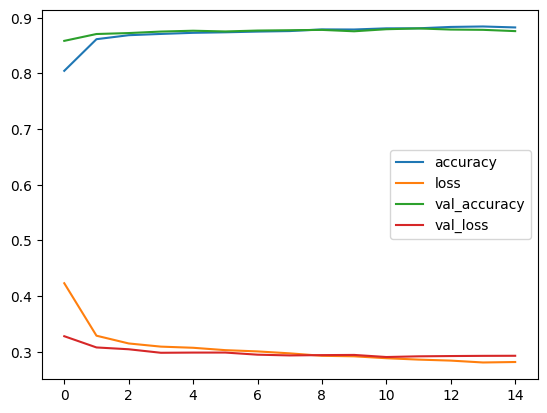

In [25]:
loss=pd.DataFrame(model.history.history)
loss.plot()

In [26]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Classification report is:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5000
           1       0.89      0.85      0.87      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Confusion Matrix is:


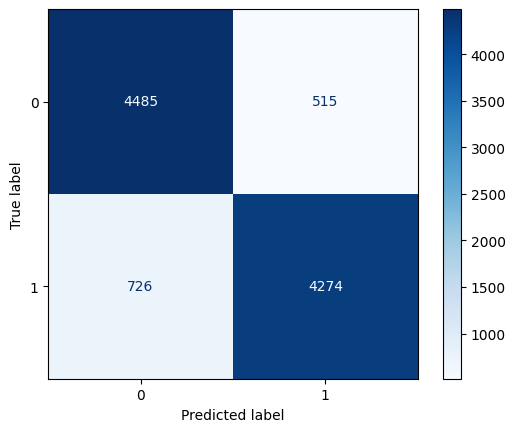

In [27]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print('Classification report is:')
print(classification_report(y_test,y_pred))
print('\n')
print('Confusion Matrix is:')
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap='Blues')